In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [6]:
df = pd.read_csv('STRIPS_data.csv')

In [7]:
df

,Date,Price_Feb25,Time_Feb25,Yield_Feb25,Price_May25,Time_May25,Yield_May25,Price_Aug25,Time_Aug25,Yield_Aug25,Price_Nov25,Time_Nov25,Yield_Nov25
0,2024-01-02,95.111,1.158111,0.04539,94.075,1.409993,0.04524,93.263,1.659138,0.04361,92.252,1.911020,0.04371
1,2024-01-03,95.102,1.155373,0.04559,94.072,1.407255,0.04535,93.310,1.656400,0.04336,92.264,1.908282,0.04370
2,2024-01-04,95.087,1.152635,0.04585,94.013,1.404517,0.04592,93.193,1.653662,0.04423,92.163,1.905544,0.04437
3,2024-01-05,95.114,1.149897,0.04593,94.057,1.401780,0.04585,93.206,1.650924,0.04437,92.203,1.902806,0.04433
4,2024-01-08,95.115,1.141684,0.04603,94.053,1.393566,0.04598,93.238,1.642710,0.04422,92.229,1.894593,0.04424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,2025-01-23,99.743,0.098563,0.03796,98.727,0.350445,0.04206,97.703,0.599589,0.04194,96.678,0.851472,0.04233
277,2025-01-24,99.743,0.095825,0.03796,98.764,0.347707,0.04195,97.730,0.596851,0.04207,96.720,0.848734,0.04222
278,2025-01-27,99.743,0.087611,0.03796,98.784,0.339493,0.04164,97.772,0.588638,0.04147,96.760,0.840520,0.04183
279,2025-01-28,99.743,0.084873,0.03796,98.800,0.336756,0.04149,97.787,0.585900,0.04139,96.769,0.837782,0.04186


In [8]:
#Get the time to maturity and yields for all the STRIPS
times = np.array([
    df['Time_Feb25'].values,
    df['Time_May25'].values,
    df['Time_Aug25'].values,
    df['Time_Nov25'].values
])

yields = np.array([
    df['Yield_Feb25'].values,
    df['Yield_May25'].values,
    df['Yield_Aug25'].values,
    df['Yield_Nov25'].values
])


In [11]:
#Vasicek model calibration
def vasicek_yield(t, r0, kappa, theta, sigma):
    B = (1- np.exp(-kappa * t)) / kappa
    A = (theta - sigma**2 / (2 * kappa**2)) * (B - t) - (sigma**2 * B**2) / (4 * kappa)
    return (A - B * r0) / t

In [12]:
def vasicek_error(params):
    r0, kappa, theta, sigma = params
    error = 0
    for i in range(len(times)):
        model_yields = vasicek_yield(times[i], r0, kappa, theta, sigma)
        error += np.sum((yields[i] - model_yields)**2)
        
    return error

In [13]:
#Initial parameter guess and bounds
intial_guess = [yields[0][0], 0.1, np.mean(yields), 0.01]
bounds = [(0, None), (0, None), (0, None), (0, None)]

In [14]:
#Calibrate the model
result = minimize(vasicek_error, intial_guess, method='L-BFGS-B', bounds=bounds)

/var/folders/p2/s867_82x1zb758ysgxvlj2yw0000gn/T/ipykernel_28193/92681714.py:3: RuntimeWarning: invalid value encountered in divide
  B = (1- np.exp(-kappa * t)) / kappa
/var/folders/p2/s867_82x1zb758ysgxvlj2yw0000gn/T/ipykernel_28193/92681714.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  A = (theta - sigma**2 / (2 * kappa**2)) * (B - t) - (sigma**2 * B**2) / (4 * kappa)


In [18]:
#Print calibrated parameters
print('Vasicek Model Parameters')
print(f'r0 : {result.x[0]:.6f}')
print(f'kappa : {result.x[1]:.6f}')
print(f'theta : {result.x[2]:.6f}')
print(f'sigma : {result.x[3]:.6f}')

Vasicek Model Parameters
r0 : 0.019223
kappa : 0.079117
theta : 0.019369
sigma : 0.432088


In [21]:
#Calculate model fit
def calculate_rmse():
    total_error = 0
    total_points = 0
    r0, kappa, theta, sigma = result.x

    for i in range(len(times)):
        model_yields = vasicek_yield(times[i], r0, kappa, theta, sigma)
        total_error += np.sum((yields[i] - model_yields)**2)
        total_points += len(times[i])

    return np.sqrt(total_error/total_points)

print(f'Model Fit (RMSE): {calculate_rmse():.6f}')

Model Fit (RMSE): 0.038963


Plots

In [23]:
import matplotlib.pyplot as plt

In [22]:
# Get the latest date for plotting
latest_date = df['Date'].max()
latest_data = df[df['Date'] == latest_date]

# Prepare observed data points
maturities = np.array([
    latest_data['Time_Feb25'].values[0],
    latest_data['Time_May25'].values[0],
    latest_data['Time_Aug25'].values[0],
    latest_data['Time_Nov25'].values[0]
])

observed_yields = np.array([
    latest_data['Yield_Feb25'].values[0],
    latest_data['Yield_May25'].values[0],
    latest_data['Yield_Aug25'].values[0],
    latest_data['Yield_Nov25'].values[0]
])

/var/folders/p2/s867_82x1zb758ysgxvlj2yw0000gn/T/ipykernel_28193/92681714.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return (A - B * r0) / t


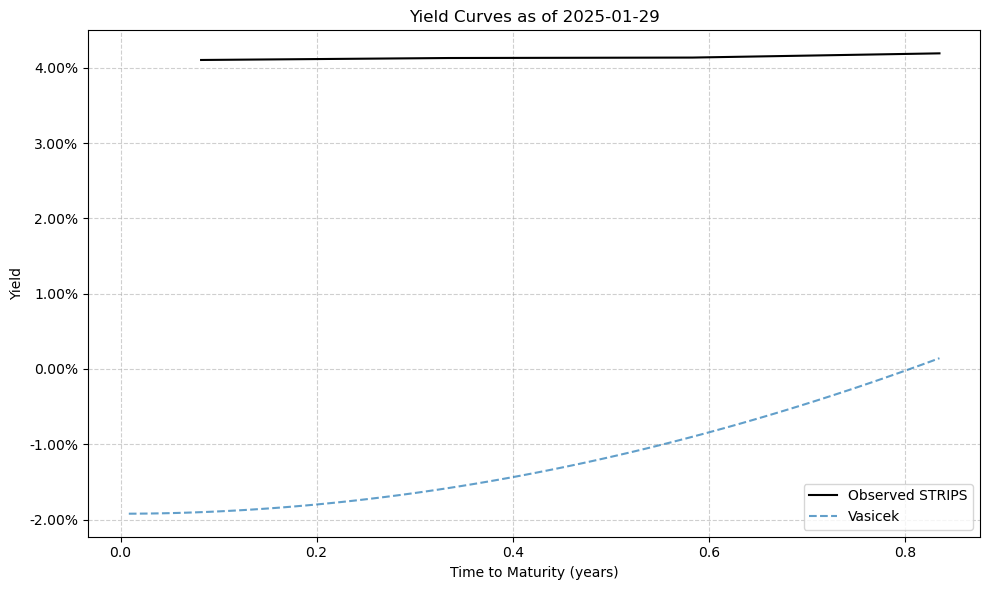

In [27]:

# Generate points for smooth curves
t = np.linspace(0, max(maturities), 100)

# Calculate model yields using the calibrated parameters
r0 = result.x[0]
kappa = result.x[1]
theta = result.x[2]
sigma = result.x[3]

vasicek_params = [r0, kappa, theta, sigma]  # [r0, kappa, theta, sigma]

# Generate model yields
vasicek_yields = [vasicek_yield(ti, *vasicek_params) for ti in t]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot observed STRIPS yields
plt.plot(maturities, observed_yields, color='black', label='Observed STRIPS', zorder=5)

# Plot model-fitted curves
plt.plot(t, vasicek_yields, '--', label='Vasicek', alpha=0.7)

# Customize the plot
plt.title(f'Yield Curves as of {latest_date}')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Yield')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

plt.tight_layout()
plt.show()